# <ins>Project Title</ins>: 

## Implenting Golden Cross Trading Strategy with Python

# <ins>Created By</ins>: 

## Daniel Ramirez Jr.

# <ins>Project Description</ins>:
## Type: Personal (For Fun)


### Required Libraries and Codes


In [165]:
#import necessary libraries
import pandas as pd
import requests
import numpy as np
import matplotlib.pyplot as plt
import math
import datetime
import seaborn as sns

### Retrieve the Daily Adjusted Prices

Returns a clean 

In [4]:
def dailyAdjustedPrices(api_key,symbol):
    
    #getting the time series data
####################################################################################    
    #this url contains the format needed to make the api call for time series data
    daily_prices_url = 'https://www.alphavantage.co/query?function=TIME_SERIES_DAILY_ADJUSTED&symbol=' + symbol + '&outputsize=full' +'&apikey=' + api_key

    #makes the api request/call
    daily_price_request = requests.get(daily_prices_url)

    #stores the values into a dictionary
    daily_prices = daily_price_request.json()

    #stores the relevant information into a dictionary
    dictionary_of_dp = daily_prices['Time Series (Daily)']

    #convert this json into a dataframe, where the keys are the rows and the values are the columns 
    historical_prices = pd.DataFrame.from_dict(dictionary_of_dp, orient = 'index')
    
    #the indexes are the dates thus make that a column labeled reportedDate because that will be the key column for the inner join
    historical_prices['Trading_Date'] = historical_prices.index

    #reset the index since its a column now
    historical_prices.reset_index(drop=True, inplace=True)    
    
    #filter the trading date column from oldest to most recent to run the SMA properly
    historical_prices = historical_prices.sort_values(by='Trading_Date')
    
    #remember that the model could break if there is not enough historical data
    return historical_prices

In [5]:
test_dailyAdjustedPrices = dailyAdjustedPrices(api_key,ticker)
test_dailyAdjustedPrices.head(20)

,1. open,2. high,3. low,4. close,5. adjusted close,6. volume,7. dividend amount,8. split coefficient,Trading_Date
5533,60.63,60.63,58.31,58.63,6.74366495386,178000,0.0000,1.0,1999-11-01
5532,58.63,58.81,58.19,58.75,6.75746744055,90800,0.0000,1.0,1999-11-02
5531,59.0,59.38,58.25,59.38,6.82993049565,64300,0.0000,1.0,1999-11-03
5530,59.38,59.94,59.13,59.25,6.81497780174,92700,0.0000,1.0,1999-11-04
5529,59.38,60.0,59.38,59.88,6.88744085685,60000,0.0000,1.0,1999-11-05
5528,59.75,59.75,59.56,59.63,6.85868567625,26500,0.0000,1.0,1999-11-08
5527,59.69,59.69,59.31,59.56,6.85063422568,74700,0.0000,1.0,1999-11-09
5526,59.56,59.88,59.38,59.44,6.836831739,39000,0.0000,1.0,1999-11-10
5525,59.25,59.38,59.0,59.06,6.79312386449,31300,0.0000,1.0,1999-11-11
5524,59.13,59.13,57.88,58.0,6.67120189875,59200,0.0000,1.0,1999-11-12


In [6]:
#create a function to clean the columns and reogranize how it looks
#function takes on dataframe as parameter
def dpCleaner(dailyAdjustedPrice):
    #make a copy of the dataframe 
    historical_prices = dailyAdjustedPrice.copy(deep =True)

    #rename the columns:
    
    #create a dictionary with all the name changes
    dict_column_names = {'1. open': 'Open', '2. high': 'High','3. low':'Low','5. adjusted close':"Adjusted_Close",'6. volume':'Volume'}
    
    #rename the columns accordingly
    historical_prices = historical_prices.rename(columns=dict_column_names)
    
    #specify what columns should be kept
    relevant_columns = ['Trading_Date','Open','High','Low','Adjusted_Close','Volume']
    
    #filter the dataframe to contain only the relevant columns
    historical_prices = historical_prices.loc[:,relevant_columns] 
    
    #change the dataTypes of the columns to numeric, accordingly, in order to perform calculations
    historical_prices= historical_prices.apply(pd.to_numeric, errors='ignore')
    
    #drop the open,high,low
    historical_prices = historical_prices.drop(['Open','High','Low'], axis=1)

    
    #return the dataframe
    return historical_prices


In [7]:
test_dpCleaner = dpCleaner(test_dailyAdjustedPrices)
test_dpCleaner.head(20)

,Trading_Date,Adjusted_Close,Volume
5533,1999-11-01,6.743665,178000
5532,1999-11-02,6.757467,90800
5531,1999-11-03,6.829930,64300
5530,1999-11-04,6.814978,92700
5529,1999-11-05,6.887441,60000
5528,1999-11-08,6.858686,26500
5527,1999-11-09,6.850634,74700
5526,1999-11-10,6.836832,39000
5525,1999-11-11,6.793124,31300
5524,1999-11-12,6.671202,59200


In [8]:
#function to create the necessary variables for the analysis

def dpCalculation(cleanDataFrame):
    #create a copy of the dataFrame that was inserted
    calculation_dataFrame = cleanDataFrame.copy(deep=True)
    
    #the following columns must be created in order to create variables:
    
    #column that contains the 50 SMA; its an average starting with the day before (n-1):
    calculation_dataFrame['50 SMA'] = calculation_dataFrame['Adjusted_Close'].rolling(window=50).mean()
    
    #columns that contains the 200 SMA; its an average starting with the day before (n-1)
    calculation_dataFrame['200 SMA'] = calculation_dataFrame['Adjusted_Close'].rolling(window=200).mean()
    
    #since no more moving averages will be used in this function, the dataframe can be sorted back to most recent to most oldest
    calculation_dataFrame = calculation_dataFrame.sort_values(by='Trading_Date',ascending=False)
    
    #column that contains the golden cross value where 1 = golden cross occured and 0 = no golden cross
    #this counts the unique golden crosses where the previous trading date had a 50 SMA less than the 200 SMA
    calculation_dataFrame['Golden Cross'] = ((calculation_dataFrame['50 SMA'] > calculation_dataFrame['200 SMA']) & (calculation_dataFrame['50 SMA'].shift(-1) < calculation_dataFrame['200 SMA'].shift(-1)) & (calculation_dataFrame['50 SMA'].shift(-2) < calculation_dataFrame['200 SMA'].shift(-2)) & (calculation_dataFrame['50 SMA'].shift(-3) < calculation_dataFrame['200 SMA'].shift(-3)) & (calculation_dataFrame['50 SMA'].shift(-4) < calculation_dataFrame['200 SMA'].shift(-4))).astype(int)
     
    #column that calculates the price difference between each period
    calculation_dataFrame['Period Price Change'] = calculation_dataFrame['Adjusted_Close'] - calculation_dataFrame['Adjusted_Close'].shift(-1)
    
    #column where 1 =  gain and 0 = loss
    calculation_dataFrame['Direction'] = (calculation_dataFrame['Period Price Change'] > 0).astype(int)    
    
    #column that takes the absolute value of the period price change and that is next to the direction column
    calculation_dataFrame['ABS Period Price Change'] = abs(calculation_dataFrame['Period Price Change'])

    #return the calculation dataframe
    return calculation_dataFrame

In [9]:
test_dpCalculation = dpCalculation(test_dpCleaner)
test_dpCalculation.head(20)

,Trading_Date,Adjusted_Close,Volume,50 SMA,200 SMA,Golden Cross,Period Price Change,Direction,ABS Period Price Change
0,2021-10-27,214.95,937732,214.770800,224.383892,0,-3.26,0,3.26
1,2021-10-26,218.21,563041,214.738000,224.438368,0,0.52,1,0.52
2,2021-10-25,217.69,1010393,214.654800,224.470553,0,-1.71,0,1.71
3,2021-10-22,219.40,559137,214.573800,224.521825,0,0.99,1,0.99
4,2021-10-21,218.41,1054512,214.424600,224.557912,0,0.26,1,0.26
5,2021-10-20,218.15,673970,214.324400,224.573453,0,1.91,1,1.91
6,2021-10-19,216.24,938644,214.322600,224.556480,0,0.64,1,0.64
7,2021-10-18,215.60,1034703,214.341600,224.548314,0,-3.35,0,3.35
8,2021-10-15,218.95,952256,214.390341,224.554785,0,-1.42,0,1.42
9,2021-10-14,220.37,874207,214.386232,224.540347,0,1.24,1,1.24


In [10]:
#create a function that creates the calculations needed to perform RSI
def RSICalculator(test_dpCalculation):
    #make a copy to manipulate
    avgLossGainDf = test_dpCalculation.copy(deep = True)
    
    #Loss section:
    ###############
    
    #create loss column: if direction is 0 (meaning loss) then assign the loss value to the loss column
    avgLossGainDf.loc[avgLossGainDf['Direction'] == 0, 'Loss Column'] = avgLossGainDf['ABS Period Price Change']
    
    #if the price change is a gain, assign 0 to the loss column
    avgLossGainDf.loc[avgLossGainDf['Direction'] == 1, 'Loss Column'] = 0
        
    #gain section:
    ###############    
    
    #create the gain column: if direction is 1 (meaning gain) then assign the gain value to the gain column
    avgLossGainDf.loc[avgLossGainDf['Direction'] == 1, 'Gain Column'] = avgLossGainDf['ABS Period Price Change']

    #if the price change is a loss, assign gain value to the gain column
    avgLossGainDf.loc[avgLossGainDf['Direction'] == 0, 'Gain Column'] = 0
    
    #necessary filter to make sure calculations are done correctly:
    
    #filter the dataframe back to oldest to recent so that rolling mean calculations can work
    avgLossGainDf = avgLossGainDf.sort_values(by='Trading_Date')
    
    #calculate the rolling averages after the dataframe has been sorted to oldest to recent
    #AVG Loss column that is based on the trailing 14 days
    avgLossGainDf['AVG Loss'] = avgLossGainDf['Loss Column'].rolling(14).mean()
    
    #AVG gain column that is based on the trailing 14 days
    avgLossGainDf['AVG Gain'] = avgLossGainDf['Gain Column'].rolling(14).mean()
   
    #sort the dataframe back to recent to oldest
    #since no more moving averages will be used, the dataframe can be sorted back to most recent to most oldest
    avgLossGainDf = avgLossGainDf.sort_values(by='Trading_Date',ascending=False)
    
    #RSI section:
    #############
    
    #avg gain/avg loss column
    avgLossGainDf['RS'] = avgLossGainDf['AVG Gain']/avgLossGainDf['AVG Loss']
    
    #RSI column
    avgLossGainDf['RSI'] = 100 - (100/(1+(avgLossGainDf['RS'])))   
    
    #Dataframe editing section:
    ##########################
    
    #filter out the last 200 rows because they all contain NAN values
    avgLossGainDf = avgLossGainDf.loc[avgLossGainDf['200 SMA'].notnull()]
       
    #return the dataframe with RSI information
    return avgLossGainDf

In [11]:
#this dataframe is very important as it is the basis for alot of referencing
test_RSICalculator = RSICalculator(test_dpCalculation)
print(test_RSICalculator.shape)
test_RSICalculator.head(5)


(5335, 15)


,Trading_Date,Adjusted_Close,Volume,50 SMA,200 SMA,Golden Cross,Period Price Change,Direction,ABS Period Price Change,Loss Column,Gain Column,AVG Loss,AVG Gain,RS,RSI
0,2021-10-27,214.95,937732,214.7708,224.383892,0,-3.26,0,3.26,3.26,0.00,0.757143,0.645714,0.852830,46.028513
1,2021-10-26,218.21,563041,214.7380,224.438368,0,0.52,1,0.52,0.00,0.52,0.524286,0.995000,1.897820,65.491302
2,2021-10-25,217.69,1010393,214.6548,224.470553,0,-1.71,0,1.71,1.71,0.00,0.627143,0.957857,1.527335,60.432627
3,2021-10-22,219.40,559137,214.5738,224.521825,0,0.99,1,0.99,0.00,0.99,0.505000,0.960714,1.902405,65.545809
4,2021-10-21,218.41,1054512,214.4246,224.557912,0,0.26,1,0.26,0.00,0.26,0.537857,0.890000,1.654714,62.331166


In [141]:
def goldenCrossFinder(dataFrame):    
    #reference section:
    #create a reference copy to reference
    dataFrameCopy = dataFrame.copy(deep = True)
    
    #filter the dataframe back to oldest to recent so that rolling mean calculations can work
    dataFrameCopy = dataFrameCopy.sort_values(by='Trading_Date')
    
    #reset the indexes because this will alter the data manipulation
    dataFrameCopy.reset_index(inplace=True)
    
    #delete the index; the dataframe should now have indexes starting from 0 all the way to about 5k
    del dataFrameCopy['index']    

    #get the index of the rows that contain a 1 in the golden cross column
    #this is a list of the rows where a golden cross has occurred
    golden_cross_indexes = dataFrameCopy.index[dataFrameCopy['Golden Cross']==1].tolist()
    
    #debug
#     print()
#     print("length of golden cross index list:",len(golden_cross_indexes))
#     print()
    
#     #debug info
#     #loop through each unique golden cross instance and provide the relative information:
#     for goldenCross in enumerate(golden_cross_indexes):
        
#         #debug info
#         print('This is the golden cross instance:',goldenCross[0])
#         print('This is the golden cross INDEX:',goldenCross[1])
#         print()
    
    #return the list of all the indexes where a unique golden instance occured
    return golden_cross_indexes
    
    


In [13]:
test_goldenCrossFinder = goldenCrossFinder(test_RSICalculator)
test_goldenCrossFinder


length of golden cross index list: 14

This is the golden cross instance: 0
This is the golden cross INDEX: 29

This is the golden cross instance: 1
This is the golden cross INDEX: 99

This is the golden cross instance: 2
This is the golden cross INDEX: 696

This is the golden cross instance: 3
This is the golden cross INDEX: 1398

This is the golden cross instance: 4
This is the golden cross INDEX: 1518

This is the golden cross instance: 5
This is the golden cross INDEX: 1790

This is the golden cross instance: 6
This is the golden cross INDEX: 2009

This is the golden cross instance: 7
This is the golden cross INDEX: 2262

This is the golden cross instance: 8
This is the golden cross INDEX: 2508

This is the golden cross instance: 9
This is the golden cross INDEX: 2888

This is the golden cross instance: 10
This is the golden cross INDEX: 2991

This is the golden cross instance: 11
This is the golden cross INDEX: 4190

This is the golden cross instance: 12
This is the golden cross 

[29, 99, 696, 1398, 1518, 1790, 2009, 2262, 2508, 2888, 2991, 4190, 4719, 5015]

In [128]:
#function that detects golden cross and returns a dataframe with relevant information
#includes variable that determines if the previous golden cross price is less than the following
#this helps investors understand how accurate the golden cross is for a stock

def goldenCrossInformation(dataFrame,goldenCrossIndexes):
    #the goldenCross index might be empty if a golden cross hasn't occurred yet or if the stock is new and there is not enough information in the 200 SMA
    if len(goldenCrossIndexes) == 0:
        print('No Golden Crosses or not enough data to populate 200 SMA')
        return None
    
    #create an empty list of dictionaries where the date,price,RSI,volume will be held
    list_of_golden_dictionaries = []
    
    #loop through the index list and get the data that pertains to the unique date where the golden cross occured:
    for index in goldenCrossIndexes:
        
        #master section
        ##############################
        #create a master copy to reference
        masterCopy = dataFrame.copy(deep = True)

        #filter the dataframe back to oldest to recent so that rolling mean calculations can work
        masterCopy = masterCopy.sort_values(by='Trading_Date')

        #create a copy to manipulate
        masterCopy = masterCopy.copy(deep = True)

        #reset the indexes because this will alter the data manipulation
        masterCopy.reset_index(inplace=True)

        #delete the index; the dataframe should now have indexes starting from 0 all the way to about 5k
        del masterCopy['index']
        ##############################
        
        #date variable
        date = masterCopy.iloc[index,0]
        
        #transform the date so that its broken down so that it can be put in the date() function
        year_0 = int(date[0:4])
        
        #month variable
        month_0 = int(date[5:7])
        
        #day variable
        day_0 = int(date[8:10])
        
        #transformed date_0
        date_0 = datetime.date(year_0,month_0,day_0)
        
        #adjusted price variable
        adjusted_close_price = masterCopy.iloc[index,1]
        
        #volume variable
        volume = masterCopy.iloc[index,2]
        
        #RSI variable
        rsi = masterCopy.iloc[index,14]
 
        #reference the master dataframe with all the historical prices after the index
        masterCopy = masterCopy.iloc[index:,:]
        
        #create a column that calculates the return relative to the price of the first golden cross
        masterCopy['Golden Cross Return'] = ((masterCopy['Adjusted_Close']/adjusted_close_price)-1) *100

        #create a column that contains the target variable, which will based on the return column
        #the goal is to see how long it takes a stock to appreciate by 15% after a golden cross has occured
        masterCopy['Target Variable'] = (masterCopy['Golden Cross Return'] >= 15).astype(int)
  
        #now find the index that contains the first instance of the target variables
        #list of all the instances where the stock price is 15% or greater than the reference price
        return_appreciation_indexes = masterCopy.index[masterCopy['Target Variable']==1].tolist()
                
        #the first element of the list contains the index at which the stock increased by 15% since the golden cross
        try:
            index_of_appreciation = return_appreciation_indexes[0]
        except:
            print('This Stock has recently had a golden cross and will, thus the analysis will provide the historical golden cross occurences:\n')
            break
        ###########################################
        #create a master copy to reference
        masterCopy = dataFrame.copy(deep = True)

        #filter the dataframe back to oldest to recent so that rolling mean calculations can work
        masterCopy = masterCopy.sort_values(by='Trading_Date')

        #create a copy to manipulate
        masterCopy = masterCopy.copy(deep = True)

        #reset the indexes because this will alter the data manipulation
        masterCopy.reset_index(inplace=True)

        #delete the index; the dataframe should now have indexes starting from 0 all the way to about 5k
        del masterCopy['index']
        ###########################################

        #date at 15% or greater appreciation:
        date_of_first_appreciation= masterCopy.iloc[index_of_appreciation,0]

        #transformation of date_of_first_appreciation
        year_1 = int(date_of_first_appreciation[0:4])
        
        month_1 = int(date_of_first_appreciation[5:7])
        
        day_1 = int(date_of_first_appreciation[8:10])
        
        #tranformed date 1
        date_1 = datetime.date(year_1,month_1,day_1)
        
        #price at 15% or greater appreciation
        price_of_first_appreciation = masterCopy.iloc[index_of_appreciation,1]
        
        #RSI at 15% or greater appreciation
        rsi_of_first_appreciation = masterCopy.iloc[index_of_appreciation,14]

        #calculate how long it took for the stock increase by 15% following a golden cross occurence
        apprecitation_time_period =  date_1 - date_0
        
        #only return the days
        apprecitation_time_period = apprecitation_time_period.days
        
        #create the dictionary with the correct variables (references the masterCopy)
        golden_dictionary = {'Index':index,'Date':date,'Golden_Adjusted_Close':adjusted_close_price,'Volume':volume,'RSI':rsi,'Appreciation_Date':date_of_first_appreciation,'Appreciation_Length_Days':apprecitation_time_period,'Appreciation_Price':price_of_first_appreciation,'Appreciation_RSI':rsi_of_first_appreciation}

        #add the dictionary to the list of dictionaries
        list_of_golden_dictionaries.append(golden_dictionary)
    
    
    #loop has ended
    #if the stock price of the following golden cross is less than that of the previous, remove from the list
    #thought process is that I am only interested in the length of how long it takes a stock to appreciate in price after a golden cross

    #convert the list of dictionaries into a dataframe for better visualization and variable creation
    goldenDataFrame = pd.DataFrame(list_of_golden_dictionaries)
        
    #create a column that calculates the RSI differences
    goldenDataFrame['RSI_Difference'] = goldenDataFrame['Appreciation_RSI'] - goldenDataFrame['RSI']
    
    #create a column that contains a binary value to check to see if the stock appreciated in value
    goldenDataFrame['Stock_Increase'] = (goldenDataFrame['Golden_Adjusted_Close'] > goldenDataFrame['Golden_Adjusted_Close'].shift(1)).astype(int) 
    
    #once the loop finishes return it
    return goldenDataFrame
    


In [121]:
test_goldenCrossInformation = goldenCrossInformation(test_RSICalculator,test_goldenCrossFinder)
test_goldenCrossInformation

,Index,Date,Golden_Adjusted_Close,Volume,RSI,Appreciation_Date,Appreciation_Length_Days,Appreciation_Price,Appreciation_RSI,RSI_Difference,Stock_Increase
0,29,2000-09-26,6.534327,144100,68.931159,2001-01-25,121,7.533857,87.925498,18.994338,0
1,99,2001-01-05,6.160510,134300,49.151028,2001-01-16,11,7.268159,72.894868,23.743840,0
2,696,2003-05-28,12.353226,265300,46.801347,2003-06-16,19,14.239565,86.865149,40.063802,1
3,1398,2006-03-10,25.138929,2196400,74.874372,2012-08-15,2350,29.123247,77.022059,2.147687,1
4,1518,2006-08-30,24.936493,1212300,83.391003,2012-08-15,2177,29.123247,77.022059,-6.368945,0
5,1790,2007-10-01,23.040951,2530900,66.037736,2012-07-02,1736,26.509976,91.808874,25.771138,0
6,2009,2008-08-13,20.372470,1797100,52.402746,2012-06-29,1416,24.899686,90.652386,38.249640,0
7,2262,2009-08-14,13.397614,3309000,81.521739,2009-10-15,62,15.569205,76.644737,-4.877002,0
8,2508,2010-08-06,15.872860,1054100,65.020576,2010-11-04,90,18.357307,64.576803,-0.443774,1
9,2888,2012-02-08,19.903186,1303000,63.555556,2012-06-29,142,24.899686,90.652386,27.096830,1


In [279]:
#this function provides descriptive statistics of a stock's golden cross occurences
def goldenStatistics(dataFrame):
    #create a copy to manipulate
    dfCopy = dataFrame.copy(deep = True)
    
    #RSI information at date of golden cross
    rsi_info = dataFrame['RSI']    
    sns.boxplot( y=rsi_info, palette="YlGn",showmeans=True,meanprops={"marker":"o","markerfacecolor":"white","markeredgecolor":"black","markersize":"10"},width=0.3);
    plt.title("RSI at Golden Cross", size=14)
    plt.show()
    
    #RSI on the date that the stock has appreciated by 15% or more 
    appreciation_rsi_info = dataFrame['Appreciation_RSI']
    sns.boxplot( y=appreciation_rsi_info,palette="Reds",showmeans=True,meanprops={"marker":"o","markerfacecolor":"white","markeredgecolor":"black","markersize":"10"} ,width=0.3);
    plt.title("RSI at Appreciation Date", size=14)
    plt.show()
    
    #difference in RSI
    rsi_difference = dataFrame['RSI_Difference'].describe()
    sns.boxplot( y=rsi_difference,palette="Blues",showmeans=True,meanprops={"marker":"o","markerfacecolor":"white","markeredgecolor":"black","markersize":"10"} ,width=0.3);
    plt.title("Difference in RSI", size=14)
    plt.show()
    
    #how long until the stock goes up by 15% or more after a golden cross occurence
    lengthInfo = dataFrame['Appreciation_Length_Days']
    sns.boxplot( y=lengthInfo,palette="Pastel2_r",showmeans=True,meanprops={"marker":"o","markerfacecolor":"white","markeredgecolor":"black","markersize":"10"}, width=0.3);
    plt.title("Appreciation Length (In Days)", size=14)
    plt.show()

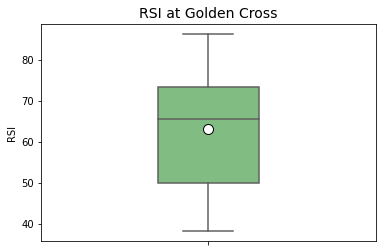

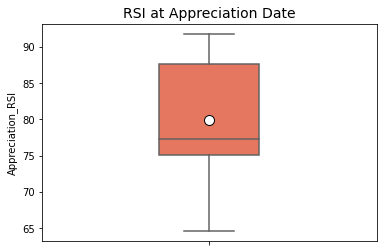

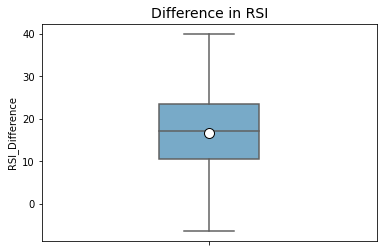

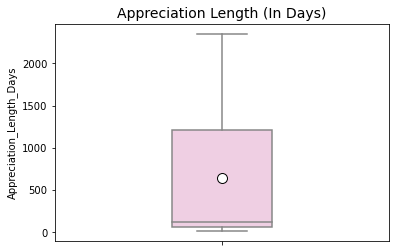

In [280]:
test_goldenStatistics = goldenStatistics(test_goldenCrossInformation)
test_goldenStatistics

In [292]:
#main function that pulls the golden cross information for any stock
#marketbeat provides a list of stocks that have had a golden cross occurence in the last week

def main():
    
    #user questions:
    ##################
    #ask the user for an API
    api_question = input('Please enter your AlphaVantage API:\n')
    print()
    #ask the user for a stock 
    stock_question = input('Please enter the stock of interest:\n')
    print()
    
    #ask the user if they want the logic of the analysis
    logic_question = input('Would you like to see the logic of the analysis? Yes or No?:\n')
    print()
    #pulling together all the functions:
    ###################################
    #get the dailyAdjusted Prices
    main_dailyAdjustedPrices = dailyAdjustedPrices(api_question,stock_question)
    
    #clean the dataframe
    main_dpCleaner = dpCleaner(main_dailyAdjustedPrices)
    
    #perform the first level of calculations on the clean dataframe
    main_dpCalculation = dpCalculation(main_dpCleaner)
    
    #perform the RSI calculations
    main_RSICalculator = RSICalculator(main_dpCalculation)
    
    #find the golden cross occurences, this returns a list
    main_goldenCrossFinder = goldenCrossFinder(main_RSICalculator)
    
    try:
        #calculate the golden cross information for the stock
        main_goldenCrossInformation = goldenCrossInformation(main_RSICalculator,main_goldenCrossFinder)    
    except:
        print('Analysis could not be done. Try another stock.')
        return None
    
    #print the stock symbol being analyzed
    print('Golden Cross Information for %s:'%(stock_question))
    print()
    
    #provide the statisitcs for the stock and its previous golden cross occurences
    try:
        main_goldenStatistics = goldenStatistics(main_goldenCrossInformation)
    except:
        print('Analysis could not be done. Try another stock.')
        return None
        
    #display type question:
    ######################
    if logic_question == 'Yes':
        #display all the data:
        
        #display prices
        display(main_dailyAdjustedPrices.head(20))
        print()

        #display cleaner
        display(main_dpCleaner.head(20))
        print()
        
        #display calculations
        display(main_dpCalculation.head(20))
        print()
        
        #display RSI
        display(main_RSICalculator.head(20))
        
        #display Golden cross info
        display(main_goldenCrossInformation)
        
        #return the stats
        display(main_goldenStatistics)
     
    #else just return the statisitcs    
    else:
        #display the table
        display(main_goldenCrossInformation.head(20))
        display (main_goldenStatistics)

Please enter your AlphaVantage API:
TQ6TR98HVUPE3L9Z

Please enter the stock of interest:
CHGG

Would you like to see the logic of the analysis? Yes or No?:
No

Golden Cross Information for CHGG:



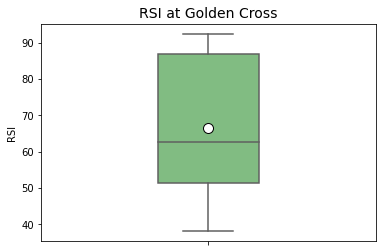

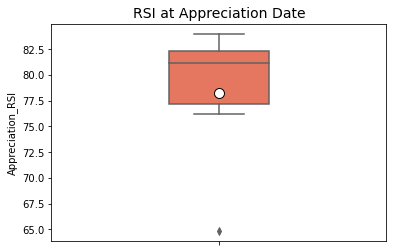

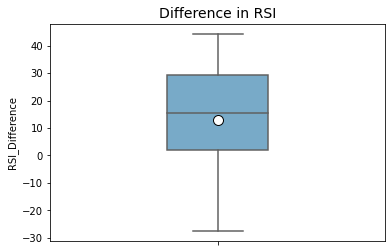

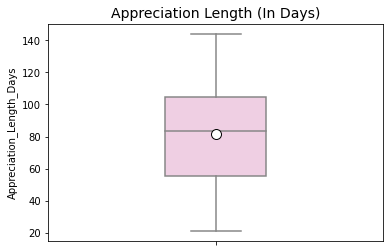

,Index,Date,Golden_Adjusted_Close,Volume,RSI,Appreciation_Date,Appreciation_Length_Days,Appreciation_Price,Appreciation_RSI,RSI_Difference,Stock_Increase
0,24,2014-10-03,6.40,464986,50.000000,2015-02-24,144,8.60,82.352941,32.352941,0
1,68,2014-12-05,6.41,385062,38.048780,2015-02-24,81,8.60,82.352941,44.304161,1
2,495,2016-08-17,6.91,404890,92.513369,2016-11-11,86,8.05,76.233184,-16.280185,1
3,1094,2019-01-04,29.88,1414901,55.073892,2019-01-25,21,34.64,84.000000,28.926108,1
4,1353,2020-01-15,41.38,1107627,70.547945,2020-05-05,111,57.92,79.993397,9.445452,1
5,1430,2020-05-06,60.40,16075330,92.454136,2020-06-22,47,69.83,64.806517,-27.647619,1


None

In [296]:
#api key
api_key = 'TQ6TR98HVUPE3L9Z'
if __name__=="__main__":
    main()   
    
